In [63]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import causalpy as cp

# Inverse Propensity Score Weighting with `pymc`

In this notebook we will briefly demonstrate how to use propensity score weighting schemes to recover treatment effects in the analysis of observational data. We will first showcase the method with a simulated data example drawn from Lucy D’Agostino McGowan's [excellent blog](https://livefreeordichotomize.com/posts/2019-01-17-understanding-propensity-score-weighting/) on inverse propensity score weighting. Then we shall apply the same techniques to NHEFS data set discussed in Miguel Hernan and Robins' _Causal Inference: What if_ book. There are a range of weighting techniques available: we have implemented `raw`, `robust`, `doubly robust` and `overlap` weighting schemes all of which aim to estimate the average treatment effect. 


## Simulated Data

First we simulate some data for treatment and outcome variables. 

In [2]:
df1 = pd.DataFrame(np.random.multivariate_normal([0.5, 1], [[2, 1], [1, 1]], size=10000), columns=['x1', 'x2'])
df1['trt'] = np.where(-0.5 + 0.25 * df1['x1'] + 0.75 * df1['x2'] +  np.random.normal(0, 1, size=10000) > 0, 1, 0)
df1['outcome'] = 2 * df1['trt'] + df1['x1'] + df1['x2'] + np.random.normal(0, 1, size=10000)
df1.head()

,x1,x2,trt,outcome
0,-0.315586,-0.033429,0,-0.753234
1,1.242359,2.186570,1,4.808943
2,0.587560,1.763649,0,2.688207
3,1.170355,1.704455,1,6.339530
4,1.210507,2.000511,1,4.731297


Note how we have specified the treatment effect of interest to be exactly 2. 

Now we invoke the `InversePropensityWeighting` experiment class, with the `PropensityScore` model. This will by default fit a simple logistic regression model and store the idata under `result1.idata`. 

In [3]:
seed = 42
result1 = cp.pymc_experiments.InversePropensityWeighting(
         df1,
         formula="trt ~ 1 + x1 + x2",
         outcome_variable ="outcome",
         weighting_scheme="robust",
         model=cp.pymc_models.PropensityScore(
             sample_kwargs={
                 "draws": 1000,
                 "target_accept": 0.95,
                 "random_seed": seed,
                 "progressbar": False,
             },
         ),
)

result1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
Sampling: [b, t_pred]
Sampling: [t_pred]


We can interrogate this inference data object in the usual fashion to assess the model fit of the propensity score model. Looking here at the parameters in the logistic regression. 

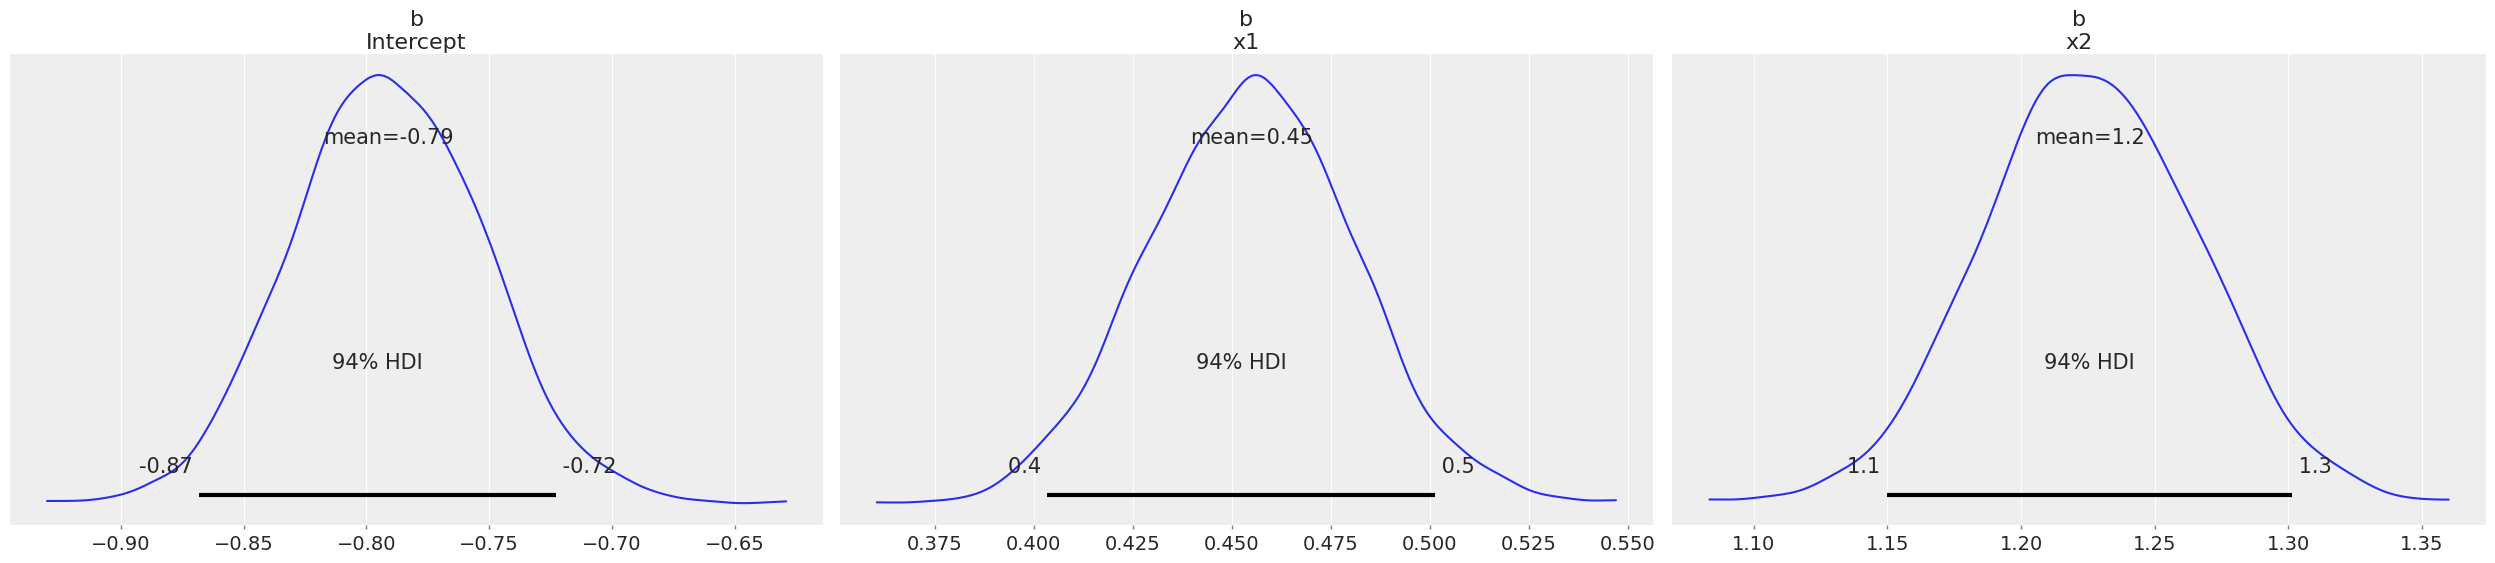

In [4]:
az.plot_posterior(result1.idata, var_names=['b']);

The health of the sampling trace.

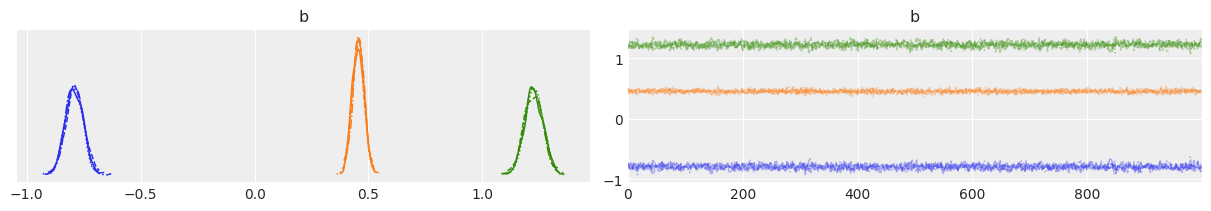

In [5]:
az.plot_trace(result1.idata, var_names=['b']);

The posterior predictive checks of our propensity model.

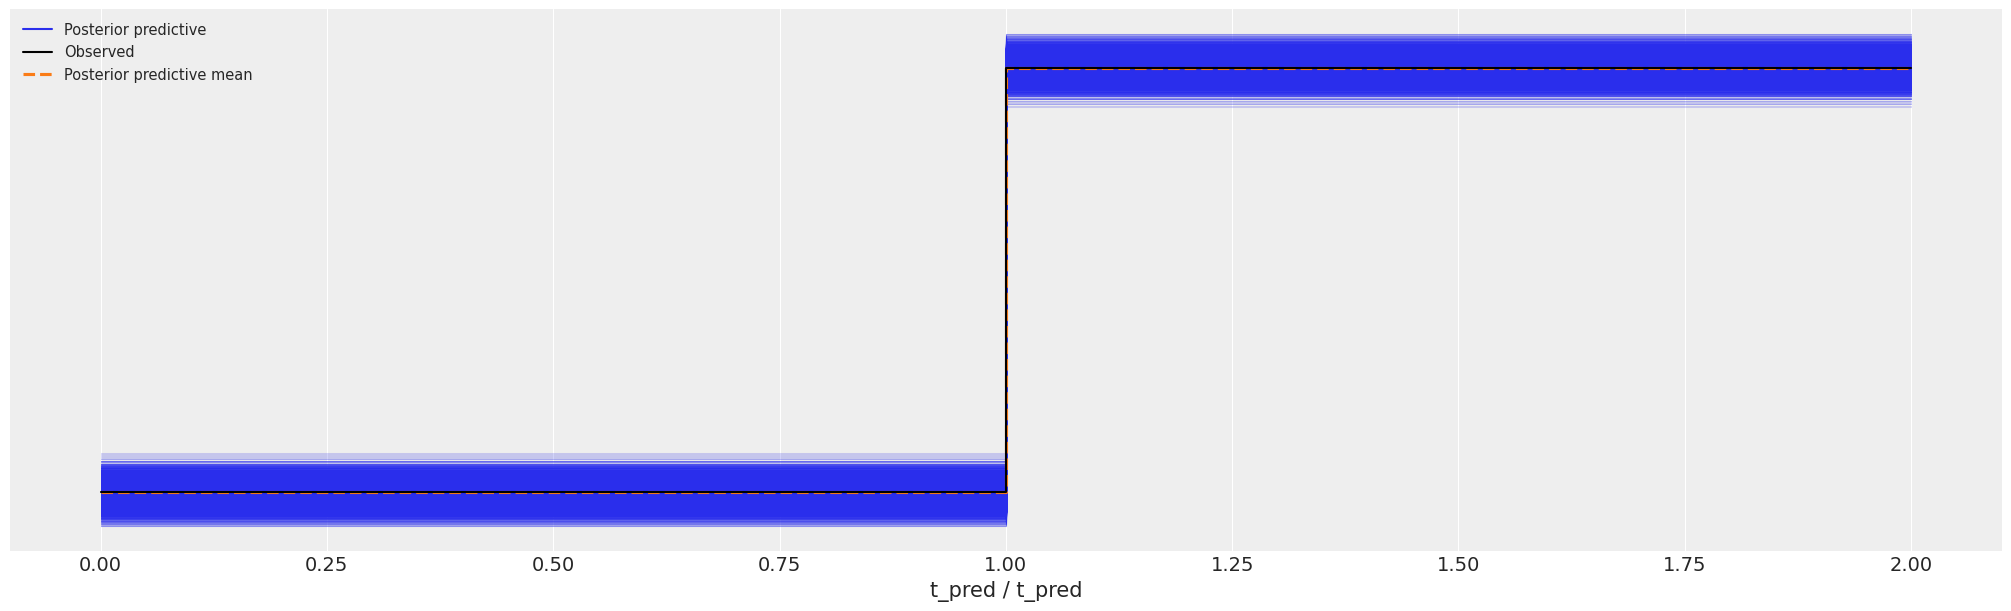

In [6]:
fig, ax = plt.subplots(figsize=(20, 6))
az.plot_ppc(result1.idata, ax=ax);

But our primary focus when we're conducting an inverse propensity weighting experiment is not on the accuracy of the propensity score model itself. Instead we want to incorporate these propensity scores latent in the logistic regression to re-weight the outcomes of interest to have a better, more representative measure of the treatment mitigating some of the risk of selection effects driving the data generating function. 

In [7]:
result1.idata['posterior']['p'].mean(dim=('chain', 'draw'))

<xarray.DataArray 'p' (p_dim_0: 10000)>
array([0.27382277, 0.92076509, 0.83714911, ..., 0.64036403, 0.76624113,
       0.51433336])
Coordinates:
  * p_dim_0  (p_dim_0) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

## Evaluating Balance

One of the main criteria for success with the estimation of propensity scores is to check how balanced the covariate profiles of our data are across the treatment status under different re-weighting schemes. A good balance of the covariate values across the treatment status is suggestive of the requirement that assignment to a treatment status should be as good as random when conditional on the covariate profile $X$. That is to say, the condition of __strong ignorability__ holds the treatment status $T$ is independent of the propensity $p(X)$ conditional on the $X$

One visual way to analyse this balance is to look at the empirical cumulative distribution function for each covariate conditional on the different realisation of propensity scores under the different weighting schemes. We can contrast the difference in the shapes of the ECDFs using the following function.

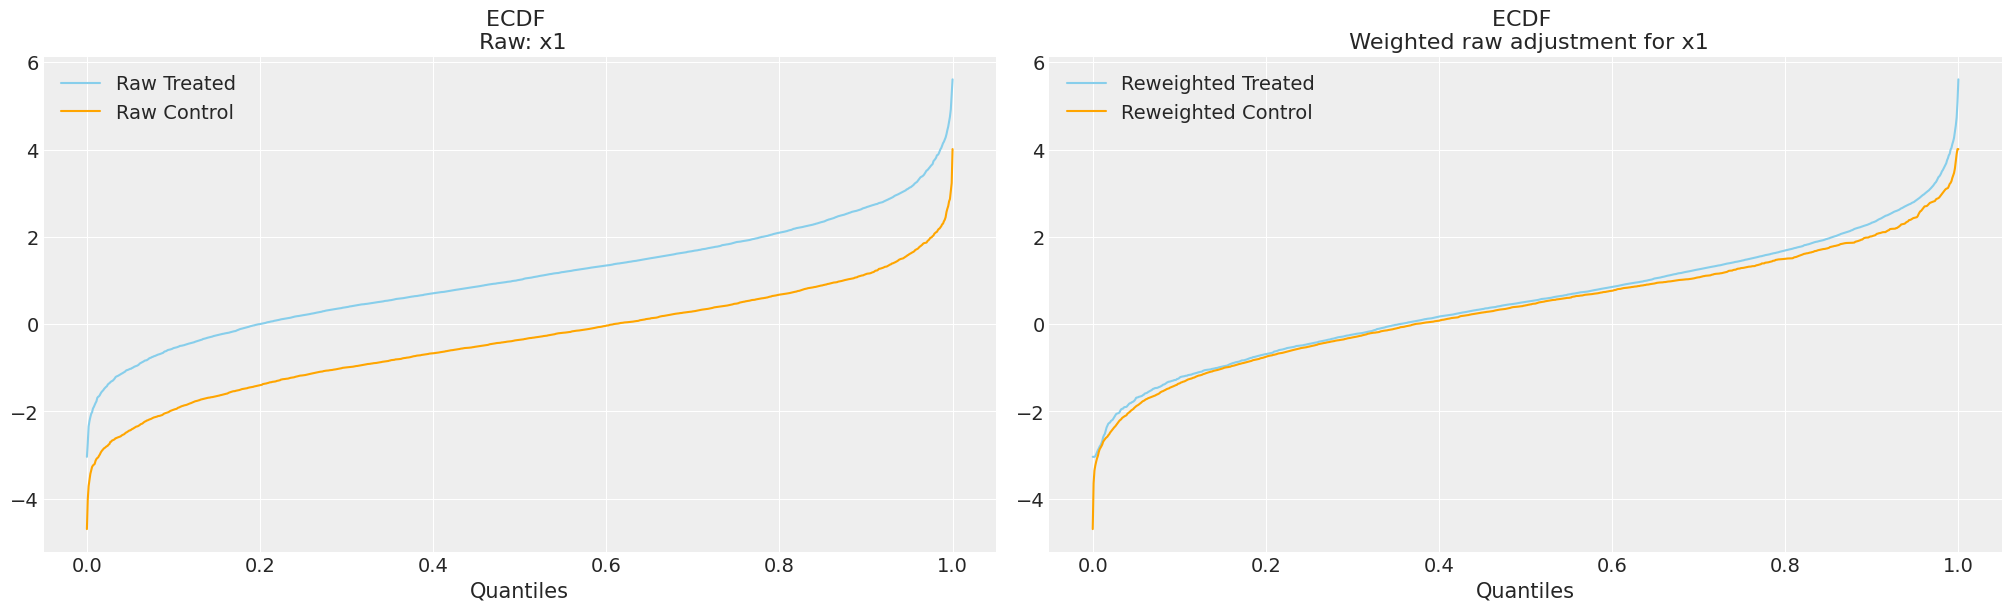

In [55]:
result1.plot_balance_ecdf('x1', weighting_scheme='raw');

Note here how the re-weighting of the variable using the robust scheme has served to align the shapes of the distribution among both treatment groups, apart from a slight gap at the upper quantiles of the re-weighted ECDF. What happens if we use a different weighting scheme?

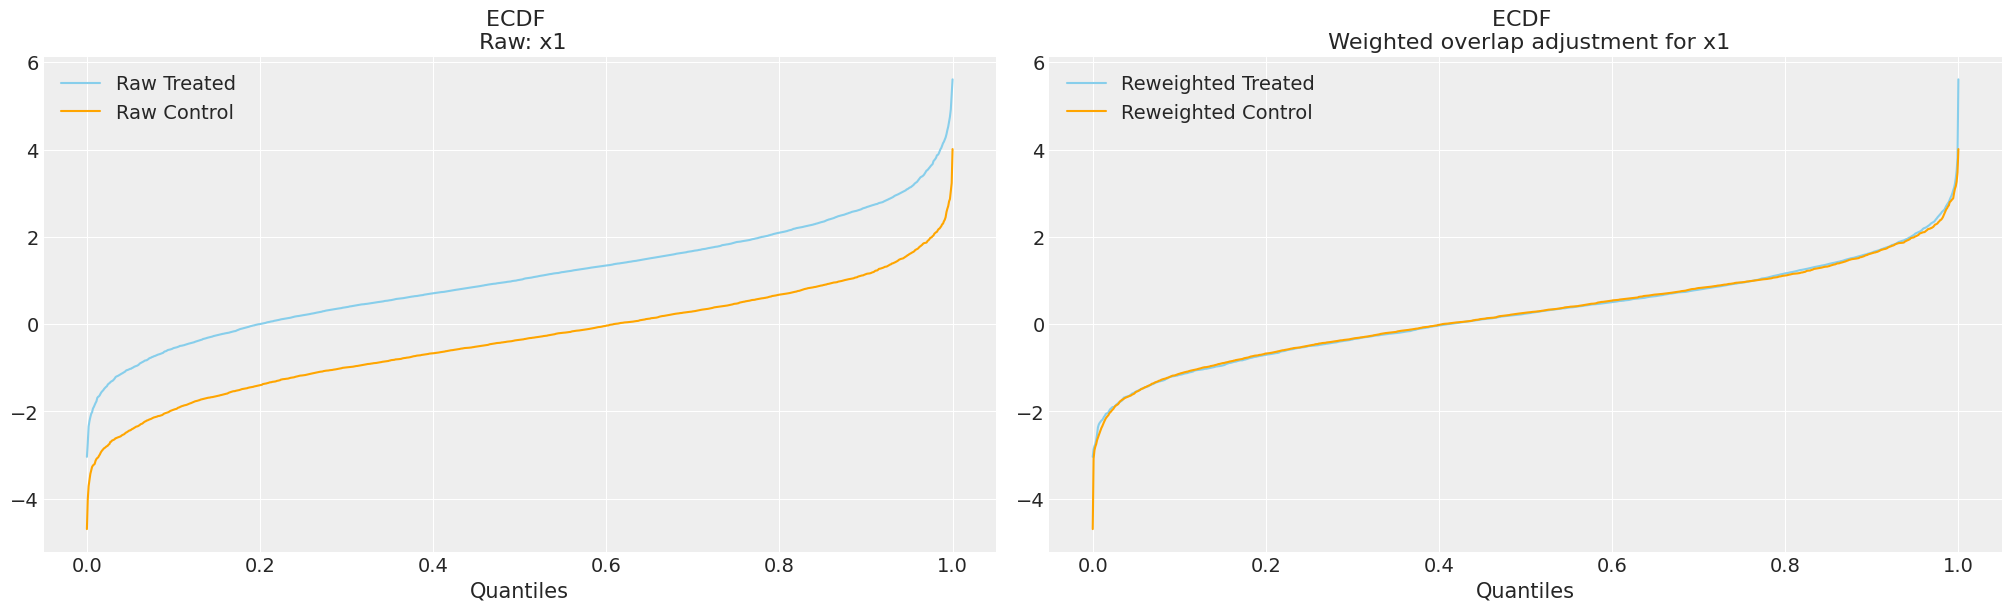

In [44]:
result1.plot_balance_ecdf('x1', weighting_scheme='overlap');

Here we see an even tighter alignment. This weighting scheme refers to the ATO: Average Treatment Effect Among the Overlap Population described in Lucy D’Agostino McGowan's linked blog. In both cases we can be reasonably happy that conditional on the propensity the weighting mechanism serves to balance the covariate distribution across the treatment effects. Next we'll look to estimate the average treatment effect under these schemes and see if we can discern differences in achieved accuracy. 


## Estimating the Average Treatment Effect

Again the `InversePropensityWeighting` class bundles the functionality to inspect the propensity score distribution and evaluate the Average treatment effect under different weighting schemes

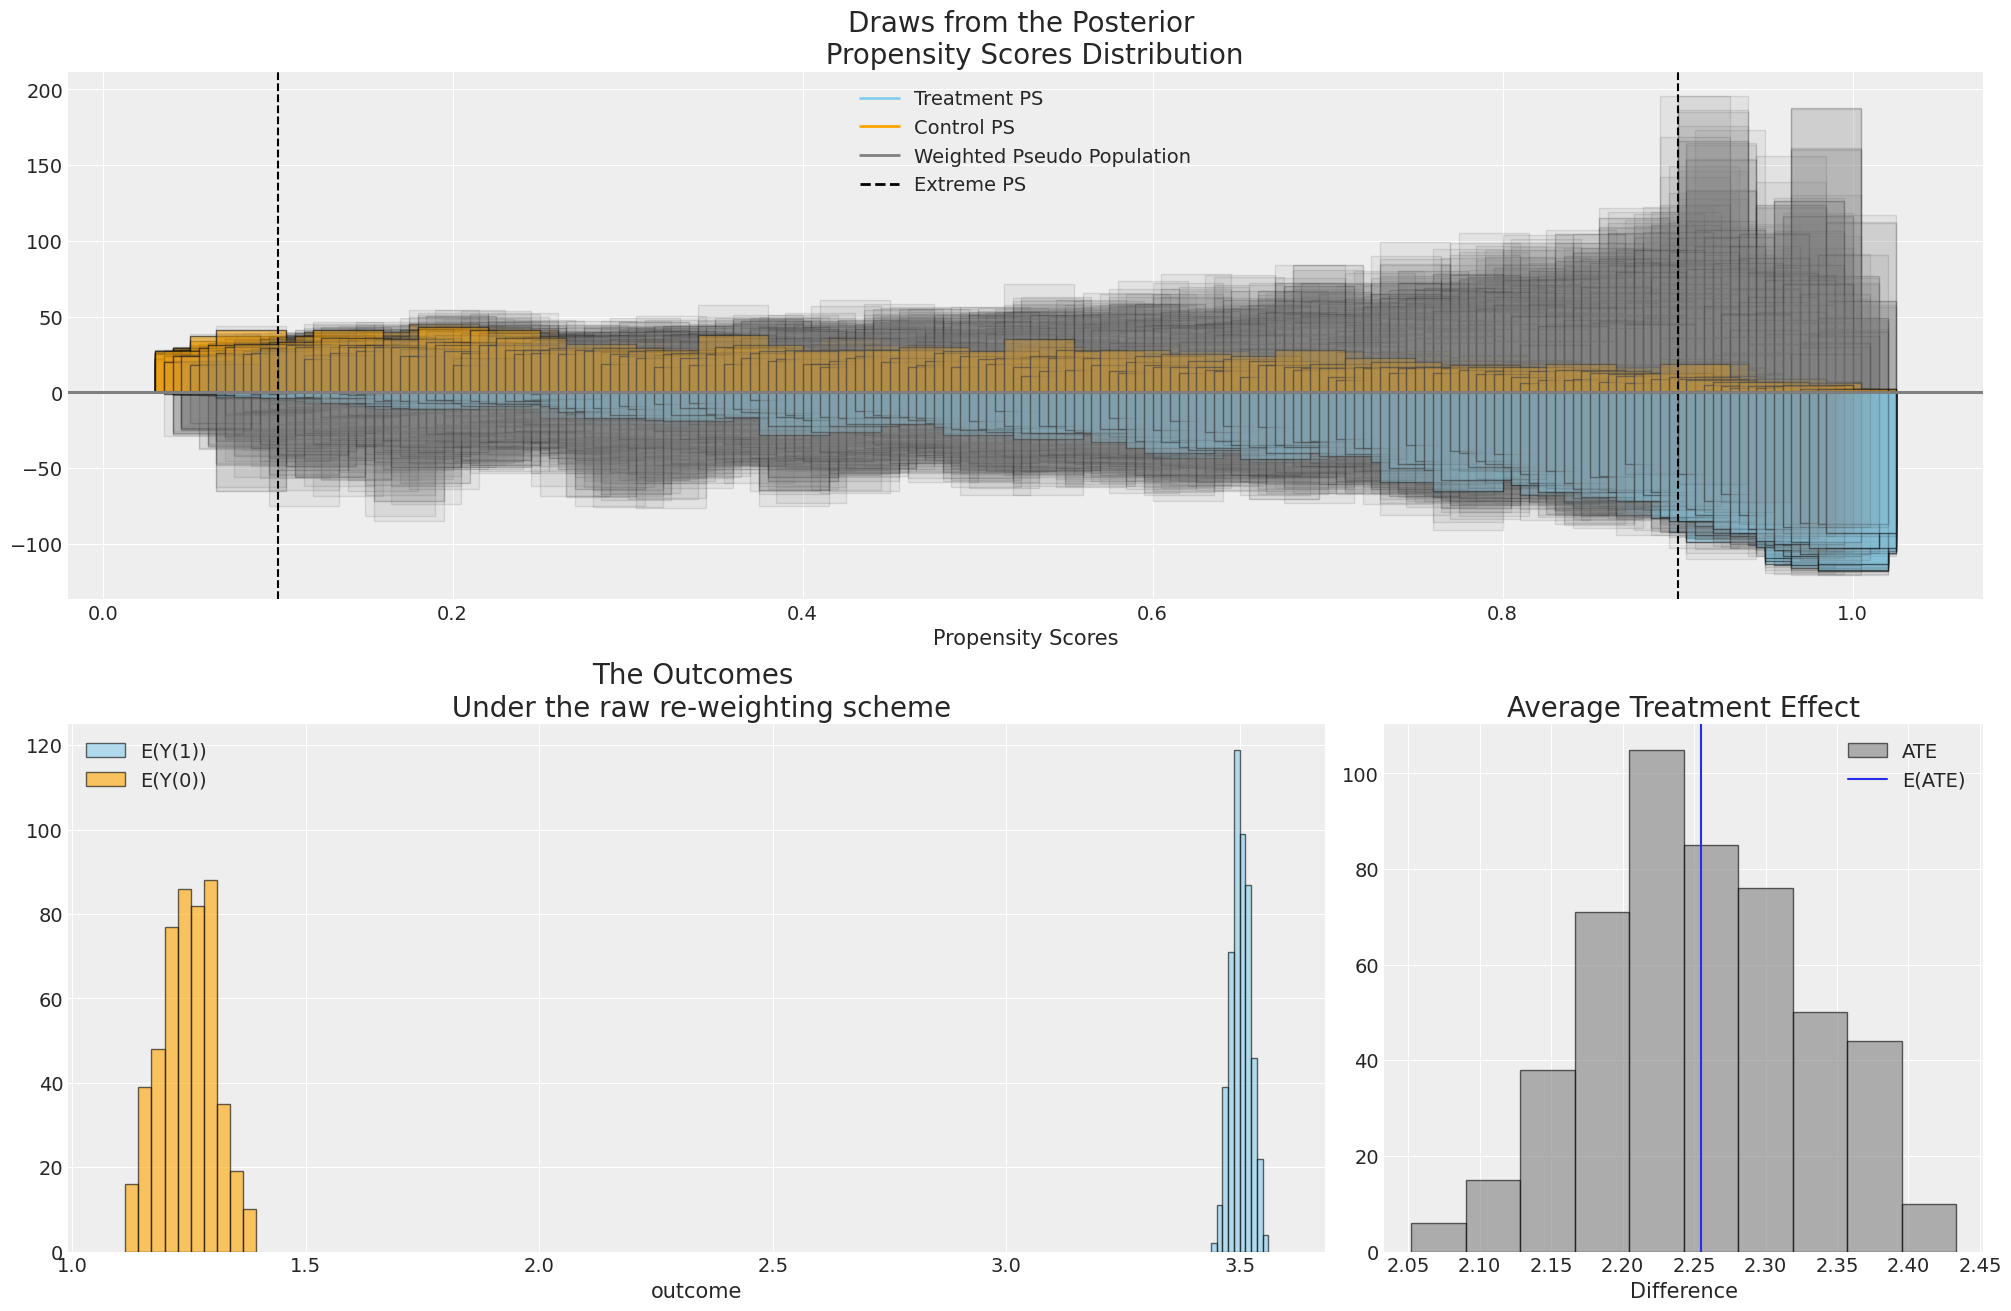

In [61]:
result1.plot_ATE(method='raw', prop_draws=10, ate_draws=500);

Here we have plotted  in three panels: (1) mirrored draws from the propensity score distribution split by treated and control groups in the red and blue with the purple showing the pseudo-population created by the weighting (2) the expected outcome in those groups under re-weighting under each draw (3) the derived estimates for the average treatment effect. Note here how expected value of the ATE is pulled slightly away from the true value under this weighting scheme. This is likely due to the high number of individuals with extreme propensity scores - denoted in (1) as individuals with propensity scores in excess of .9 and below .1.

Let's check what happens using the overlap weighting scheme?

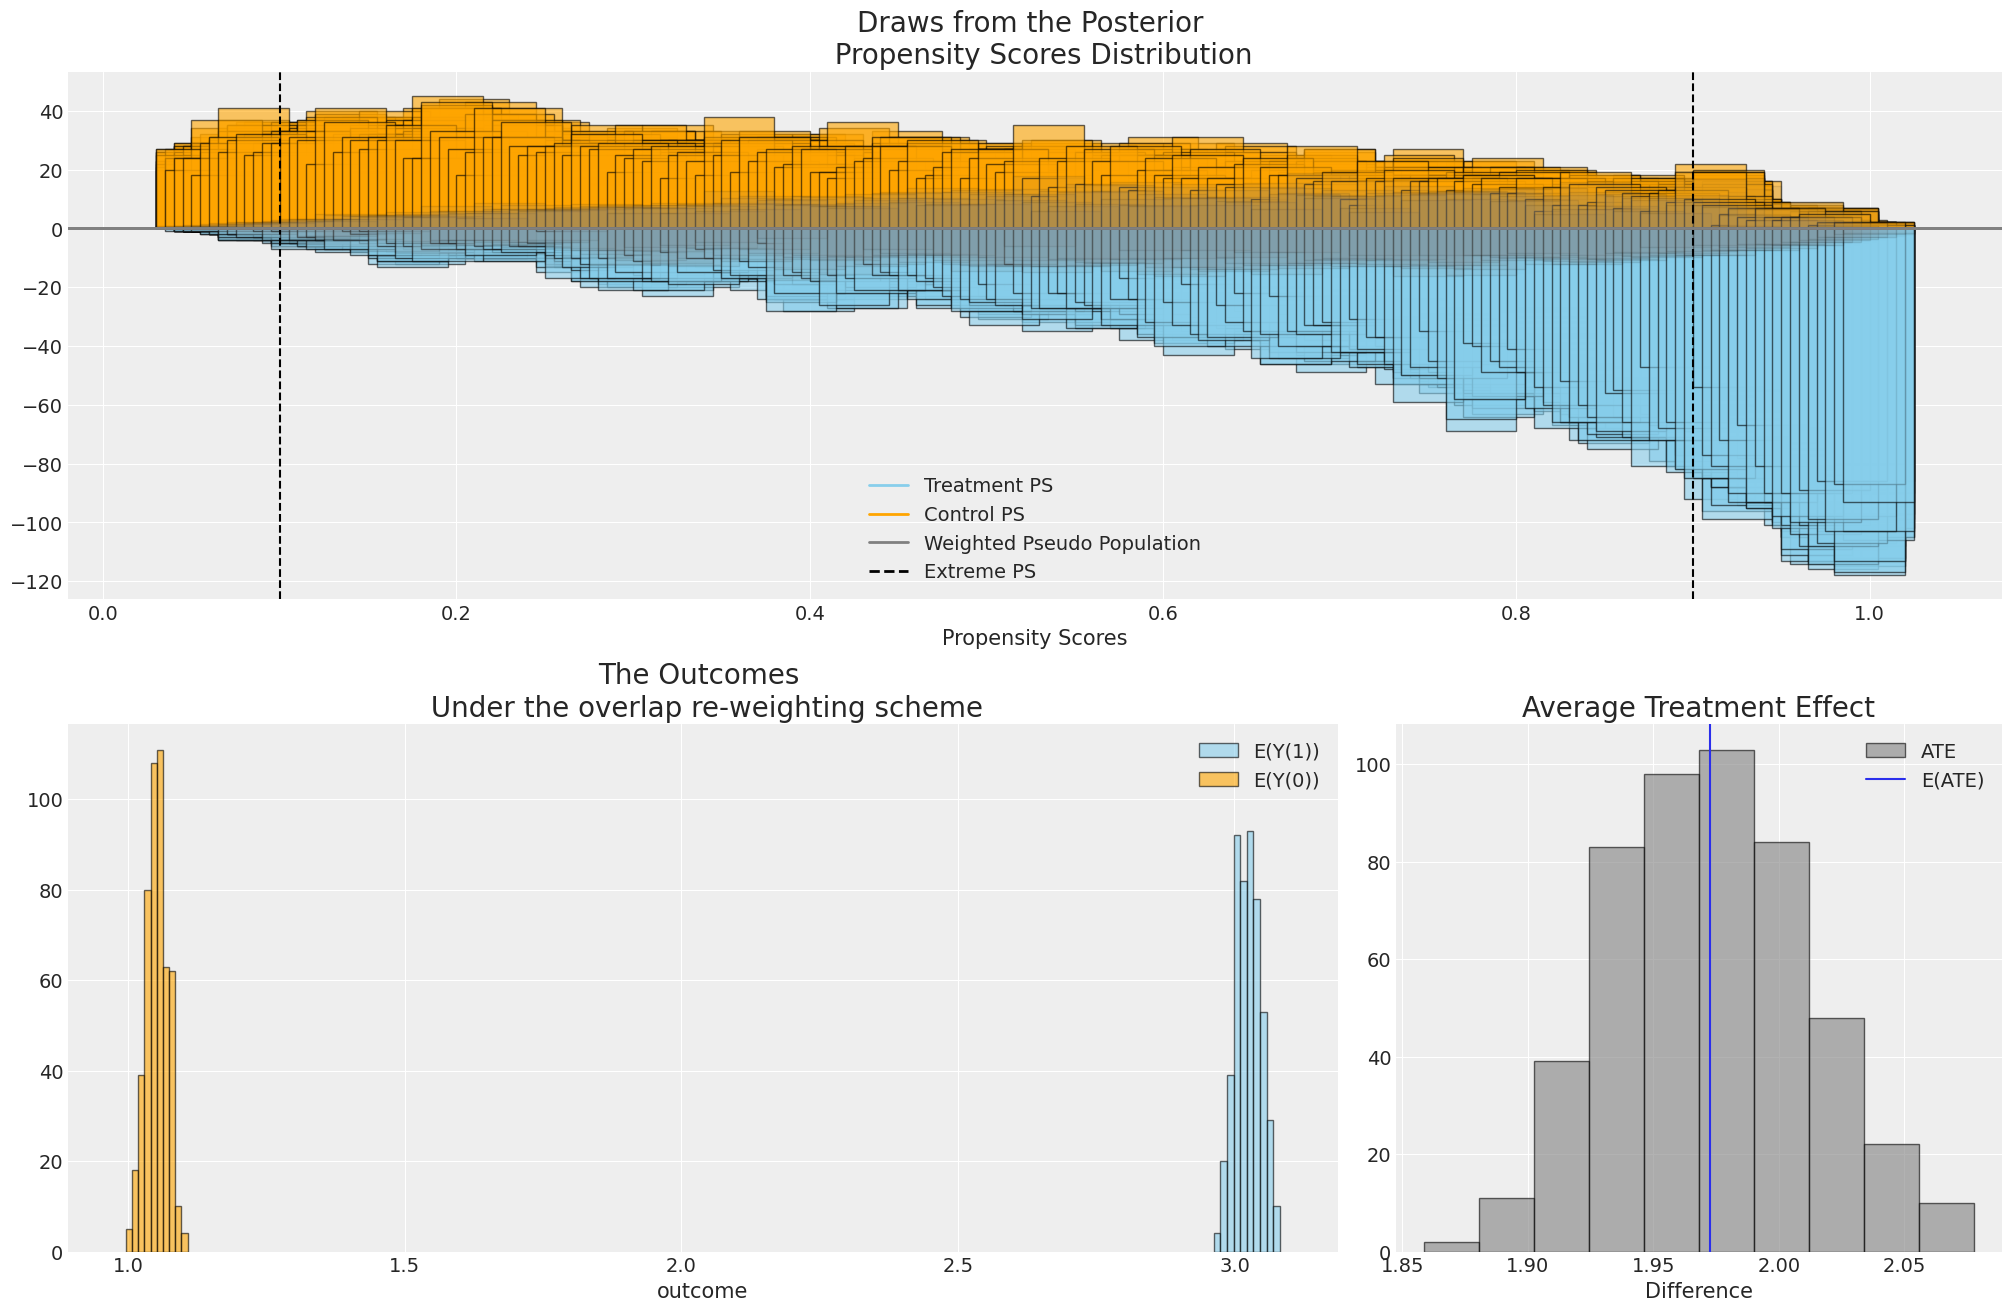

In [62]:
result1.plot_ATE(method='overlap', prop_draws=10, ate_draws=500);

We see here how the particular weighting scheme was able to recover the true treatment effect by defining a contrast in a different pseudo population. This is a useful reminder in that, while propensity score weighting methods are aids to inference in observational data. Not all weighting schemes are created equal and we need to be careful in our assessment of when each is applied appropriately. 

## NHEFS Data

Now we'll apply the same techniques to real data. This data set from the National Health and Nutrition Examination survey records details of weight, activity and smoking habits of around 1500 individuals over two periods. The first period established a baseline and a follow-up period 10 years later. We will analyse whether the individual (trt == 1) quit smoking before the follow up visit. Each individuals’ outcome represents a relative weight gain/loss comparing the two periods.

In [12]:
df = cp.load_data('nhefs')
df[['age','race', 'trt', 'smokeintensity', 'smokeyrs','outcome']].head()

,age,race,trt,smokeintensity,smokeyrs,outcome
0,42,1,0,30,29,-10.093960
1,36,0,0,20,24,2.604970
2,56,1,0,20,26,9.414486
3,68,1,0,3,53,4.990117
4,40,0,0,20,19,4.989251


In [13]:
formula="""trt ~ 1 + age + race + sex + smokeintensity + smokeyrs + wt71 + active_1 + active_2 + 
         education_2 + education_3 + education_4 + education_5 + exercise_1 + exercise_2"""

result = cp.pymc_experiments.InversePropensityWeighting(
         df,
         formula=formula,
         outcome_variable ="outcome",
         weighting_scheme="robust",
         model=cp.pymc_models.PropensityScore(
             sample_kwargs={
                 "draws": 1000,
                 "target_accept": 0.95,
                 "random_seed": seed,
                 "progressbar": False,
             },
         ),
)

result

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
Sampling: [b, t_pred]
Sampling: [t_pred]


### Evaluating Balance

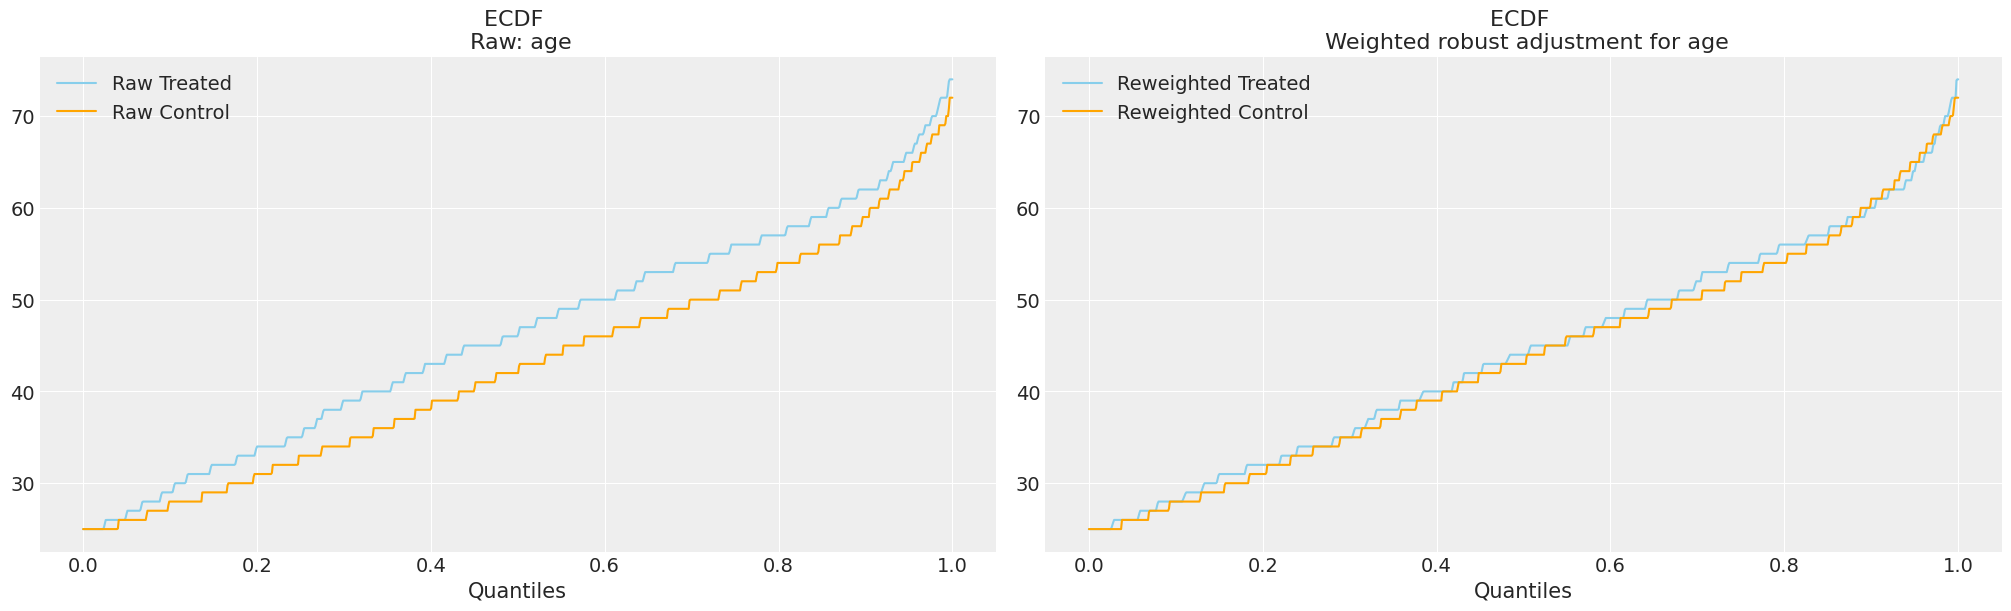

In [49]:
result.plot_balance_ecdf('age');

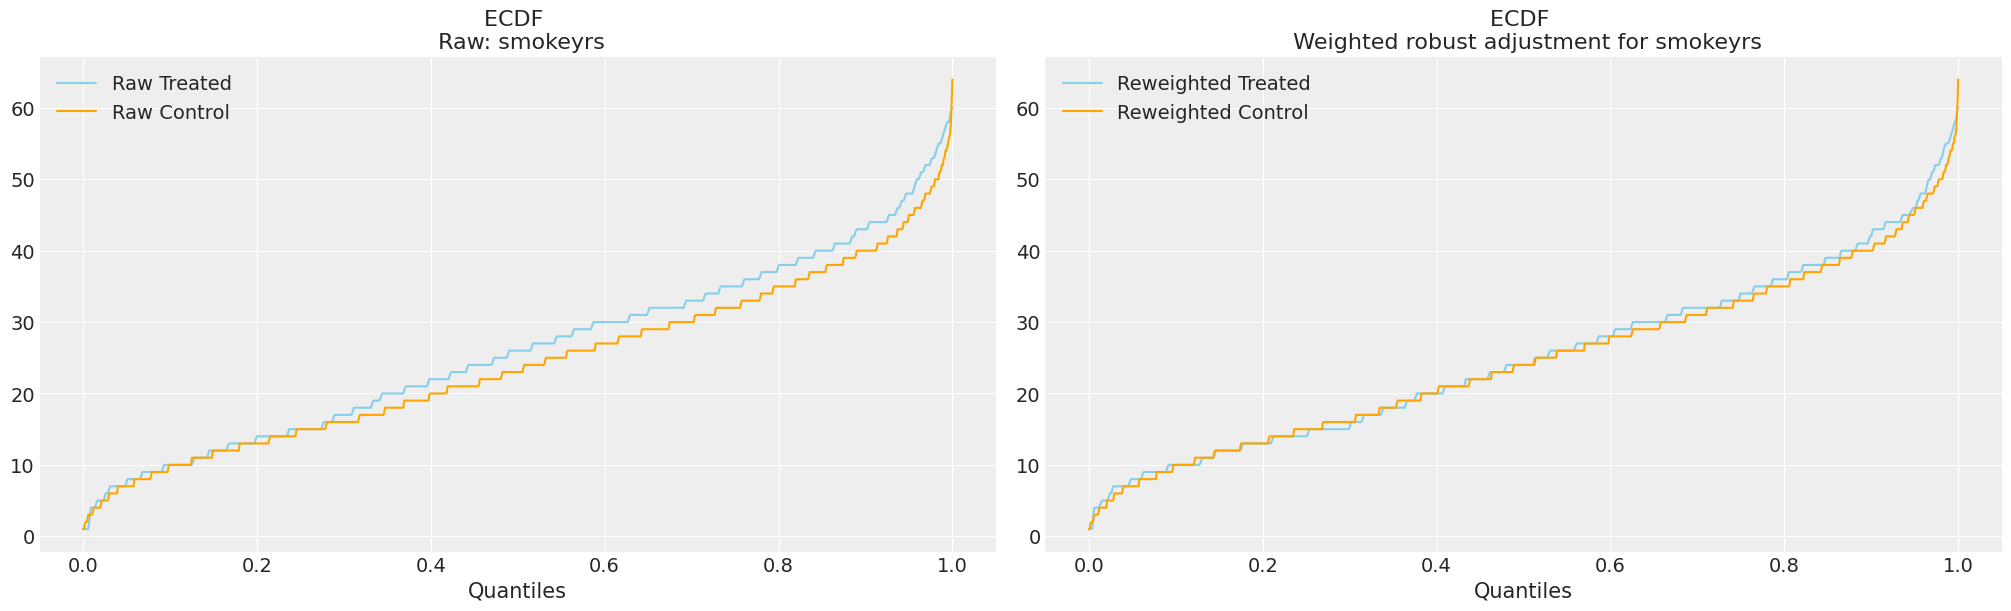

In [50]:
result.plot_balance_ecdf('smokeyrs');

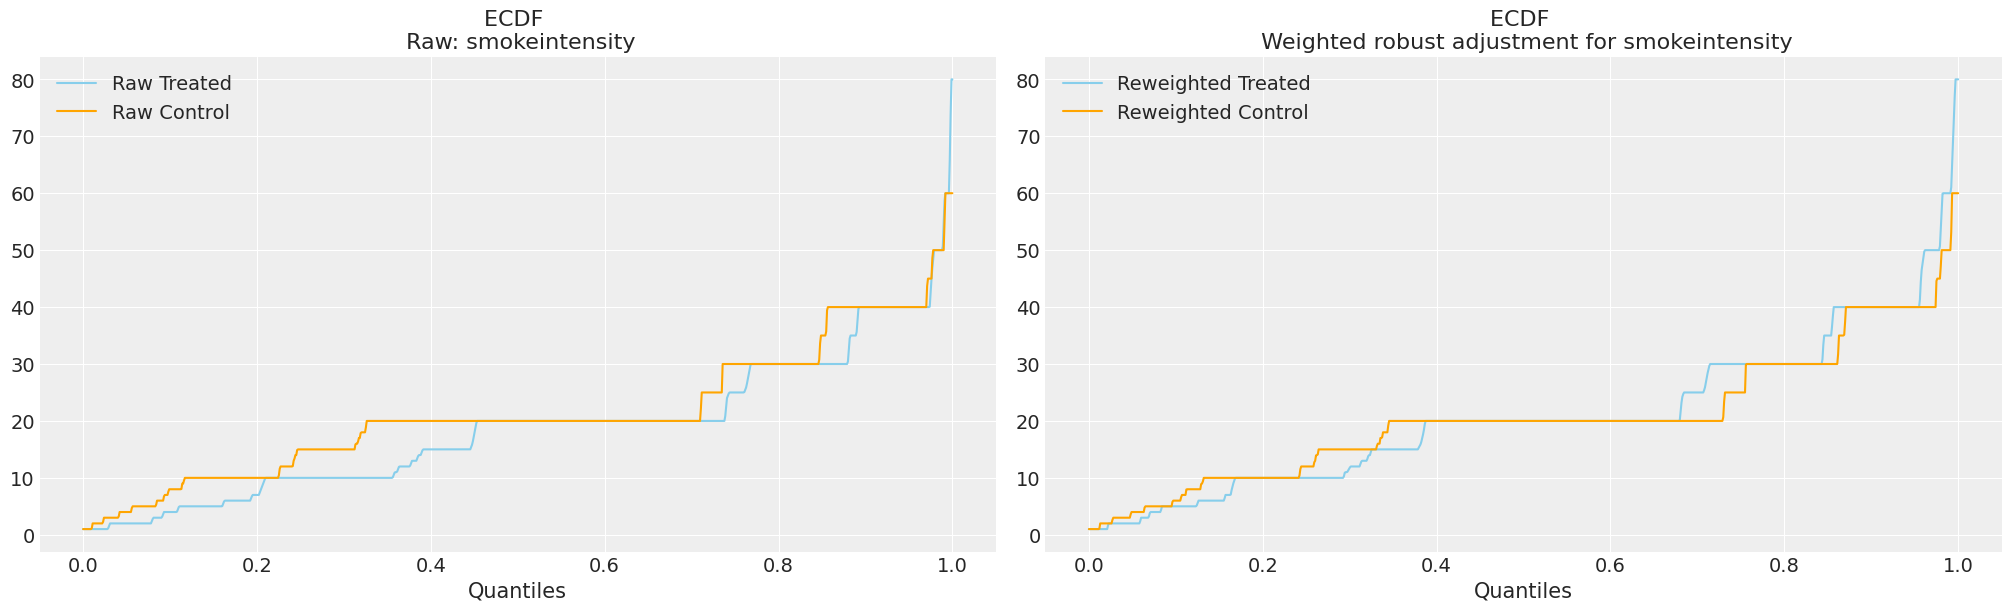

In [51]:
result.plot_balance_ecdf('smokeintensity');

In all cases re-weighting seems to have a positive effect and helps achieve conditional balance.

### Estimating the Average Treatment Effect

Here we'll use two different weighting schemes to highlight the functionality of the `robust` and `doubly robust` weighting. 

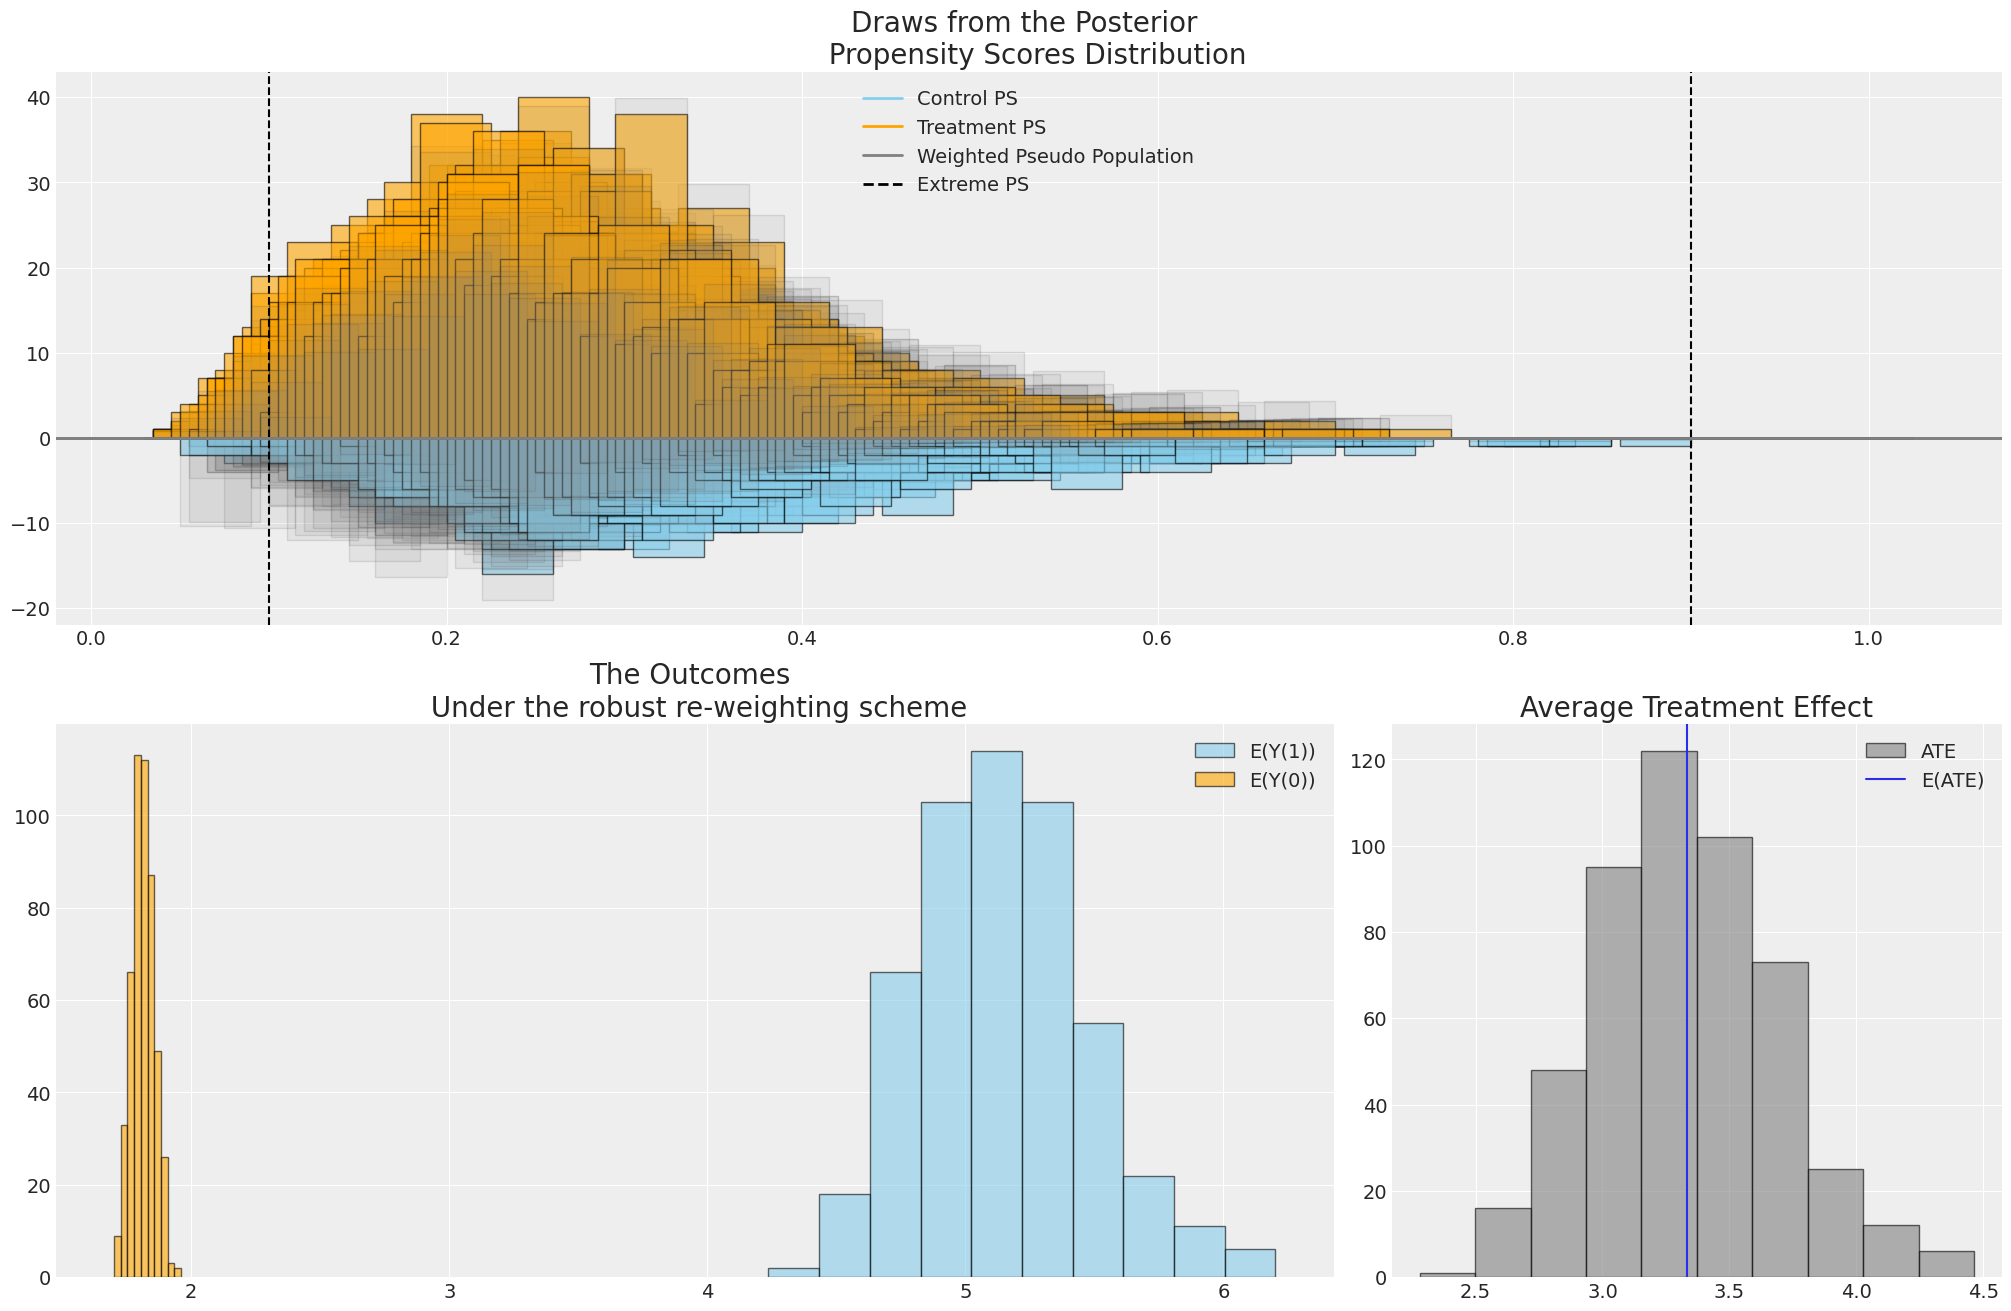

In [52]:
result.plot_ATE(method='robust', prop_draws=10, ate_draws=500);

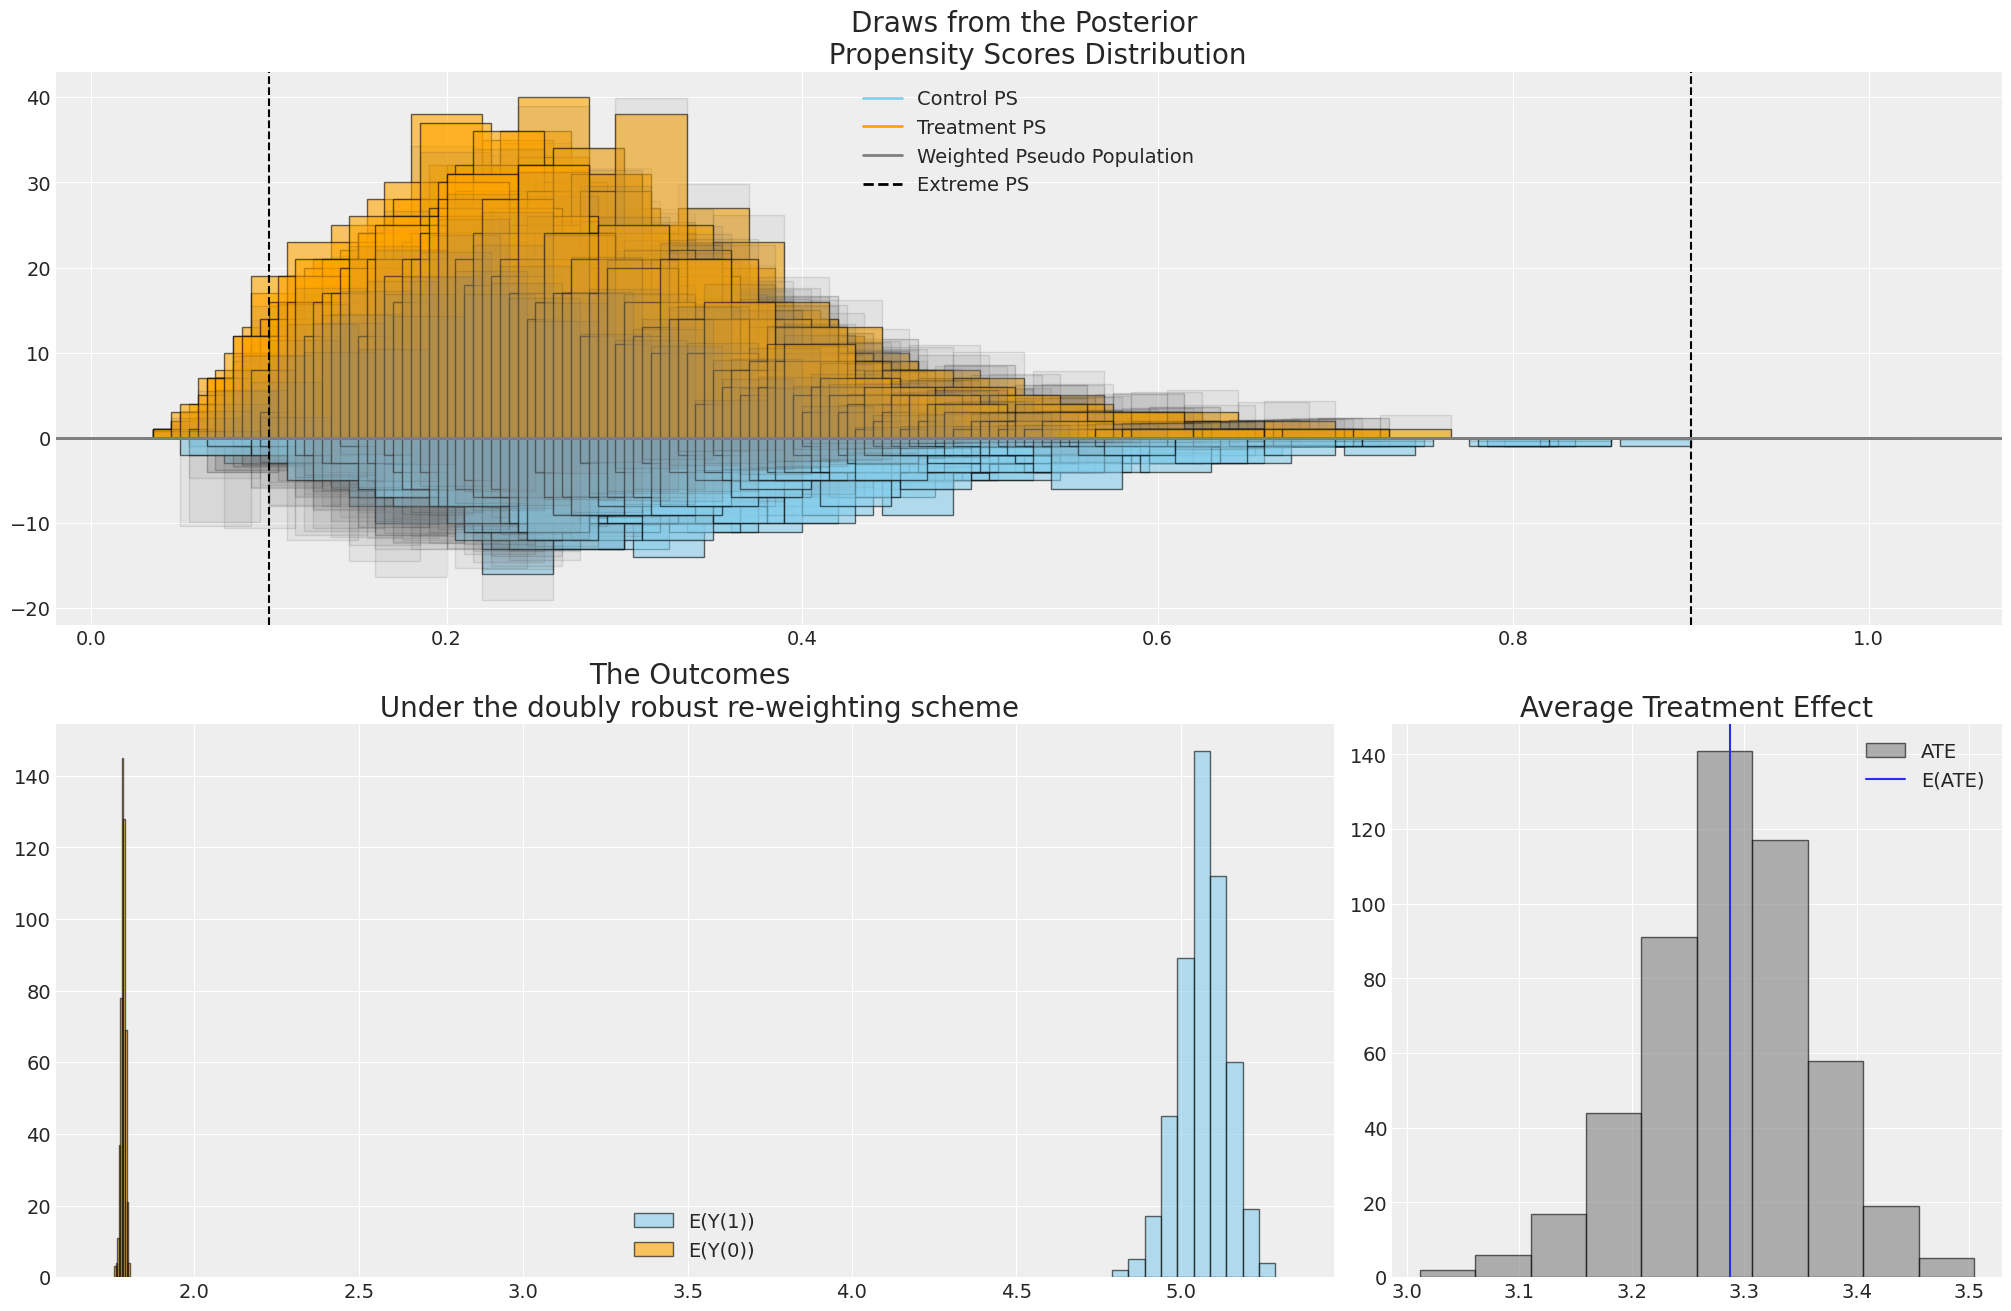

In [53]:
result.plot_ATE(method='doubly robust', prop_draws=10, ate_draws=500);

The thing to note here is that while (a) the propensity distributions for both control and treatment groups seem broadly overlapping and (b) both weighting schemes recover substantially similar effects, the variance on the doubly robust estimator is much tighter. This is aspect of the doubly robust estimator is by design and can be important where precise estimation of the treatment effects are important. 


__Note__:  
We have limited our focus and the implementation of the inverse propensity score weighting for CausalPy to a simple Logistic regression model of the propensity score. However, the analysis routines of the `InversePropensityWeighting` experiment class will run on any arviz inference data object where the propensity score posterior distribution can be identified as `p`. So this frees up the possibility of using non-parametric propensity score designs as discussed in more depth [here](https://www.pymc.io/projects/examples/en/latest/causal_inference/bayesian_nonparametric_causal.html). 

## Conclusion

This concludes our brief tour of inverse-propensity weighting experiments. Propensity modelling and propensity weighting are a powerful tool in causal inference and their potential is by no means limited to the use-cases implemented here. Thinking through the propensity score mechanism and what drives different selection effects is always a good first step in causal modelling. If the drivers of treatment choice can be modelled well propensity score adjustment is often a good way to recover the causal quantity of interest. 